## Data Visualization - H1B Visa Application Analysis 


The H1B is a visa in the United States that allows US-based companies to employ foreign workers with specialist skills and education. For international students and those who want to pursue career in the States, past application data helps understand the job market and the chance of getting visa approval.

This analysis focuses on **H1B visa applications between 2011 and 2016**, covering below topics:
1. Total Application Number
2. Visa Approval
3. Sponsor Employer
4. Wage
5. Deep Dive into Data Jobs
---------------------------------------------------------------------------------------------------------------------------
Data source: H-1B Visa Petitions 2011-2016 (https://www.kaggle.com/nsharan/h-1b-visa)

In [295]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import PercentFormatter
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import csv
from wordcloud import STOPWORDS
import warnings
warnings.filterwarnings("ignore")
!conda install -c conda-forge folium=0.5.0 --yes
import folium

Solving environment: ...working... done

# All requested packages already installed.



In [2]:
data = pd.read_csv("h1b_kaggle_raw.csv")
df = data.copy()

In [3]:
df.head()

,Unnamed: 0,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat
0,1,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,BIOCHEMISTS AND BIOPHYSICISTS,POSTDOCTORAL RESEARCH FELLOW,N,36067.0,2016.0,"ANN ARBOR, MICHIGAN",-83.743038,42.280826
1,2,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,Y,242674.0,2016.0,"PLANO, TEXAS",-96.698886,33.019843
2,3,CERTIFIED-WITHDRAWN,"PORTS AMERICA GROUP, INC.",CHIEF EXECUTIVES,CHIEF PROCESS OFFICER,Y,193066.0,2016.0,"JERSEY CITY, NEW JERSEY",-74.077642,40.728158
3,4,CERTIFIED-WITHDRAWN,"GATES CORPORATION, A WHOLLY-OWNED SUBSIDIARY O...",CHIEF EXECUTIVES,"REGIONAL PRESIDEN, AMERICAS",Y,220314.0,2016.0,"DENVER, COLORADO",-104.990251,39.739236
4,5,WITHDRAWN,PEABODY INVESTMENTS CORP.,CHIEF EXECUTIVES,PRESIDENT MONGOLIA AND INDIA,Y,157518.4,2016.0,"ST. LOUIS, MISSOURI",-90.199404,38.627003


### Data prepocessing

In [4]:
# Format YEAR
df["YEAR"].replace({2016.0:"2016", 2015.0:"2015", 2014.0:"2014", 2013.0:"2013", 2012.0:"2012", 2011.0:"2011"}, inplace=True)

In [116]:
# Check missing values
print("Total number of dataset: ", len(data))
print("Number of PREVAILING_WAGE missing value: ", data["PREVAILING_WAGE"].isnull().sum(axis=0).sum())
print("Number of YEAR missing value: ", data["YEAR"].isnull().sum(axis=0).sum())

Total number of dataset:  3002458
Number of PREVAILING_WAGE missing value:  85
Number of YEAR missing value:  13


The dataset has more than __3 million__ cases for H1B applications. As the percentage of missing value is very low, I will remove them from dataset.

In [6]:
# Remove missing values
df.dropna(subset=["YEAR"], inplace=True)
df.dropna(subset=["PREVAILING_WAGE"], inplace=True)

print("Total number of clean dataset: ", len(df))

Total number of clean dataset:  3002373


Next, let's clean up wage dataset. 

In [15]:
# Quick look on wage dataset
df.groupby("YEAR").PREVAILING_WAGE.describe()

,count,mean,std,min,25%,50%,75%,max
YEAR,,,,,,,,
2011,358754.0,194256.093500,4.631315e+06,0.0,50128.0,60882.0,77272.0,1.007814e+09
2012,415581.0,180072.839671,4.018625e+06,0.0,51626.0,62462.0,78374.4,3.783437e+08
2013,442103.0,197827.097951,1.134051e+07,7799.0,53747.0,63898.0,80704.0,6.997607e+09
2014,519414.0,181923.634331,4.184556e+06,0.0,54829.0,64917.0,81200.0,8.201323e+08
2015,618719.0,92307.028050,1.810364e+06,0.0,55890.0,66394.0,81890.0,3.067418e+08
2016,647802.0,89152.817524,1.546315e+06,0.0,57325.0,68245.0,85176.0,3.291392e+08


As can be seen from max value of prevailing wage, **the dataset is skewed towards the right due to outliers**. Also, there are data with wage 0. <br>As original dataset contains more than 3 million applications, I will clean up outliers by **removing top and bottom 5 percentiles.**

In [214]:
# Extract dataset
df_wage = df[["YEAR", "CASE_STATUS", "PREVAILING_WAGE", "JOB_TITLE", "FULL_TIME_POSITION"]]

# Remove outlier data points
Q1 = df_wage.quantile(0.25)
Q3 = df_wage.quantile(0.75)
IQR = Q3 - Q1

df_wage = df_wage[~((df_wage<(Q1-1.5*IQR))|(df_wage>(Q3+1.5*IQR))).any(axis=1)]
print("Number of outliers removed:", len(df)-len(df_wage))

Number of outliers removed: 117316


### 1. Total Application Number

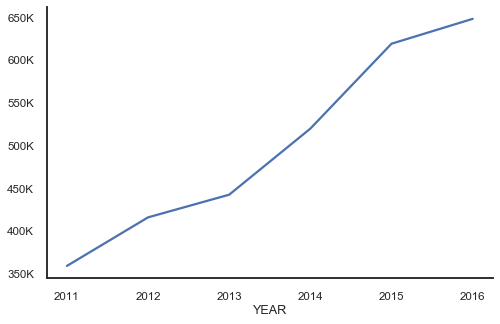

In [169]:
f, ax = plt.subplots(figsize=(8, 5))
df.groupby("YEAR")["CASE_STATUS"].count().plot()

# Format axis number
f = lambda y, pos:f'{y/10**3:,.0f}K'
ax.yaxis.set_major_formatter(FuncFormatter(f))

# Finalize the plot
sns.despine(bottom=False)

plt.show()

The number of H1B visa applications are **growing rapidly**, especially after 2013.

### 2. Visa Approval

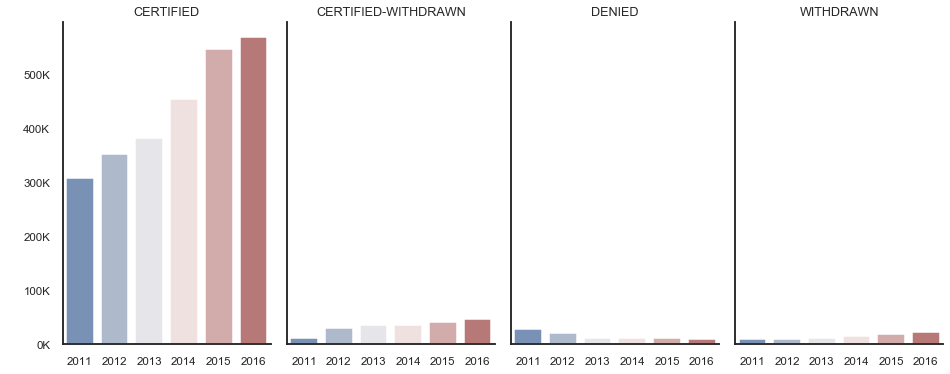

In [168]:
# Extract the dataset
df_year_status = df.groupby("YEAR")["CASE_STATUS"].value_counts()
df_year_status = df_year_status.unstack(level=1) 

# Set up the figure
sns.set(style="white", context="talk", font_scale=0.7)
f, ax = plt.subplots(1, 4, figsize=(13, 5), sharey=True)

# Plot 4 bar chart
x = np.arange(2011, 2017)
f = lambda y, pos:f'{y/10**3:,.0f}K'

for i, s in enumerate(["CERTIFIED", "CERTIFIED-WITHDRAWN", "DENIED", "WITHDRAWN"]):
    sns.barplot(x=x, y=df_year_status[s], palette="vlag", ax=ax[i])
    ax[i].set_title(s) 
    ax[i].set_ylabel(" ")
    ax[i].yaxis.set_major_formatter(FuncFormatter(f))

# Finalize the plot
sns.despine(bottom=False)
plt.tight_layout(pad=0)

 - Throughout 2011 to 2016, **the majority of applications are certified**. Good news to H1B applicants!
 - **Denied cases are decreasing** despite increasing trend of total number of applicaitons.

Nevertheless, I will explore the potential factors for those denied cases. Let's examine **if part time positions are more likely to get denied**.

In [290]:
# Extract full time job application
df_full_de = df[(df["FULL_TIME_POSITION"]=="Y") & (df["CASE_STATUS"]=="DENIED")]
df_full_ce = df[(df["FULL_TIME_POSITION"]=="Y") & (df["CASE_STATUS"].isin(["CERTIFIED", "CERTIFIED-WITHDRAWN"]))]

# Extract part time job application
df_part_de = df[(df["FULL_TIME_POSITION"]=="N") & (df["CASE_STATUS"]=="DENIED")]
df_part_ce = df[(df["FULL_TIME_POSITION"]=="N") & (df["CASE_STATUS"].isin(["CERTIFIED", "CERTIFIED-WITHDRAWN"]))]
                          
print("Full-time denial rate:", round(len(df_full_de)/(len(df_full_de)+len(df_full_ce)), 4))
print("Part-time denial rate:", round(len(df_part_de)/(len(df_part_de)+len(df_part_ce)), 4))

Full-time denial rate: 0.0325
Part-time denial rate: 0.0318


As denial rate are almost the same, **full-time or part-time doesn't make much difference**.<br>
Let's see if there's difference in **wage**.

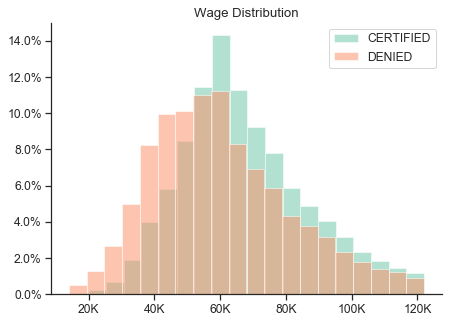

In [264]:
# Extract dataset
d = df_wage[df_wage["CASE_STATUS"]=="DENIED"]["PREVAILING_WAGE"]
c = df_wage[df_wage["CASE_STATUS"].isin(["CERTIFIED", "CERTIFIED-WITHDRAWN"])]["PREVAILING_WAGE"]

# Initialize the figure
sns.set(style="ticks", palette="Set2", font_scale=1.1)
f, ax = plt.subplots(figsize=(7, 5))

# Compare 2 histograms with y-axis as percentage
plt.hist(c, bins=20, weights=np.ones(len(c)) / len(c), alpha=0.5, label='CERTIFIED')
plt.hist(d, bins=20, weights=np.ones(len(d)) / len(d), alpha=0.5, label='DENIED')
plt.legend(loc='upper right')

#Format axis number
f = lambda x, pos:f'{x/10**3:,.0f}K'
ax.xaxis.set_major_formatter(FuncFormatter(f)) 
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

# Finalize the plot
sns.despine(bottom=False)
plt.title("Wage Distribution")
plt.show()

Compared to denied cases, wage of certified cases is relatively right-skewed. H1B application with **lower wage is more likely to get rejected**.

### 3. Sponsor Employer

Which companies are sponsoring H1B? The below Word Cloud of all employers gives an overall picture of sponsor companies.

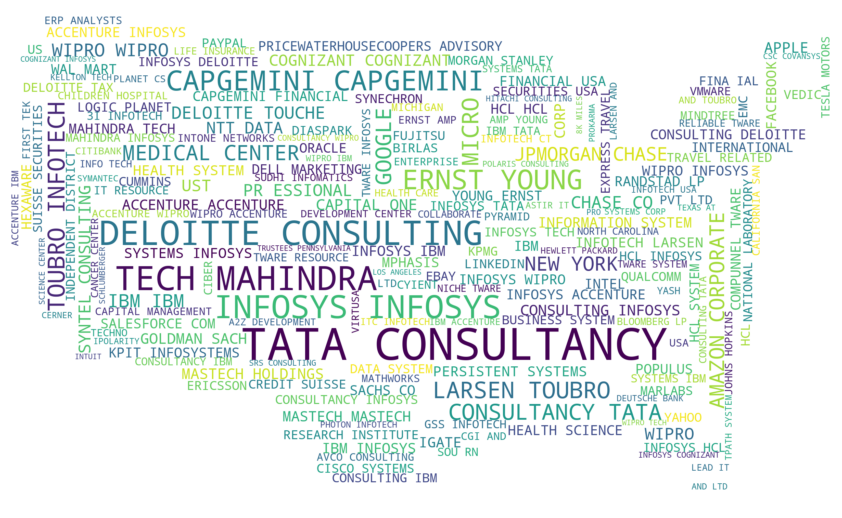

In [28]:
# Extract Employer Name from dataset
text = []
with open("h1b_kaggle_clean.csv", "r", encoding="utf-8") as f:
    reader = csv.reader(f)
    text = '\t'.join([i[0] for i in reader])
    
# Getting rid of the stopwords
for word in ["INC","OF","TECHNOLOGY","SOLUTION","STATE","INDIA","THE","UNIVERSITY","CORPORATION","SCHOOL","ASSOCIATE"]:
    if word in text:
        text = text.replace(word," ")

# Generate a word cloud on US map image
mask = np.array(Image.open("USmap.png"))

# Generate a word cloud image
wordcloud = WordCloud(mask=mask, background_color="white", 
                      max_font_size=130, min_font_size=20).generate(str(text))

# Display the generated image
plt.figure(figsize=(14,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

We can also extract **top 15 employers** who sponsor the most applications.

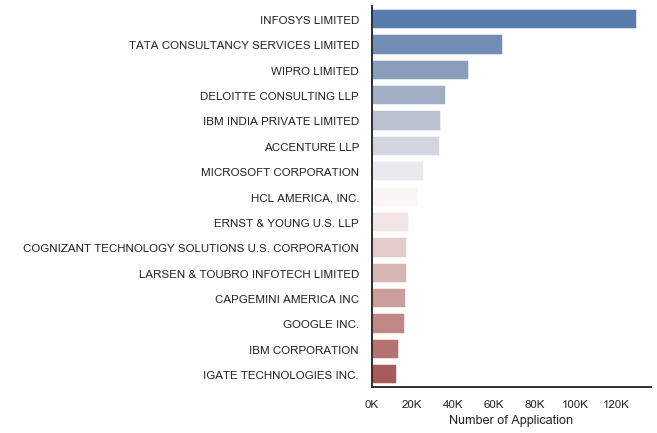

In [11]:
d = df["EMPLOYER_NAME"].value_counts().head(15)
df_ee = pd.DataFrame(data=d).reset_index()
df_ee.rename(columns={"index":"EMPLOYER_NAME", "EMPLOYER_NAME": "Number of Application"}, inplace=True)

# Initialize the figure
f, ax = plt.subplots(figsize=(5, 7))

# Plot the horizontal bar chart
sns.barplot(x="Number of Application", y="EMPLOYER_NAME", data=df_ee, palette="vlag")
ax.set_ylabel(" ")

#Format axis number
f = lambda x, pos:f'{x/10**3:,.0f}K'
ax.xaxis.set_major_formatter(FuncFormatter(f)) 

# Finalize the plot
sns.despine(bottom=False)

 - **INFOSYS is the biggest sponsor** with significant large number of applications.
 - Out of top 5 companies, **Indian IT companies** account for 4.
 - Apart from technology companies, consulting firms also sponsor many foreign workers.

### 4. H1B Wage

#### Wage Distribution by Year

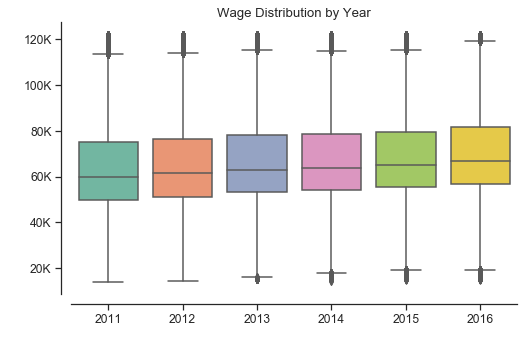

In [113]:
# Initialize the figure
sns.set(style="ticks", palette="Set2", font_scale=1.1)
f, ax = plt.subplots(figsize =(8,5), sharey=True) 

# Plot the boxplot
ax = sns.boxplot(x="YEAR", y="PREVAILING_WAGE", data= df_wage)

# Format xticks
ax.set_xticklabels(list(range(2011,2017)))

# Format axis number
f = lambda y, pos: f'{y/10**3:,.0f}K'
ax.yaxis.set_major_formatter(FuncFormatter(f))

# Finalize the plot
plt.xlabel(" ")
plt.ylabel(" ")
plt.title("Wage Distribution by Year")
sns.despine(offset=10)

Although not dramatic, there is **consistent growing trend of median wage** among H1B applicants. Let's also check if **full time or part time** position change rapidly during this period that may have impacted the wage distrubition.

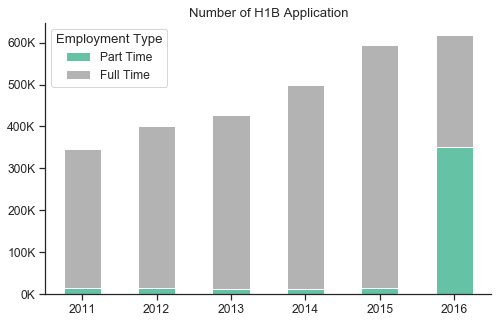

In [114]:
df_employ_type = df_wage.groupby("YEAR")["FULL_TIME_POSITION"].value_counts().unstack(level=1)
df_employ_type.index = list(range(2011, 2017))
df_employ_type.rename(columns={"N":"Part Time", "Y":"Full Time"}, inplace=True)

# Plot the stacked bar chart
ax = df_employ_type.plot(kind="bar", stacked=True, figsize=(8, 5), colormap=ListedColormap(sns.color_palette("Set2", 8)))

# Format axis number
f = lambda y, pos:f'{y/10**3:,.0f}K'
ax.yaxis.set_major_formatter(FuncFormatter(f))

# Format ticks
plt.xticks(rotation=0)

# Format legend
ax.legend(title="Employment Type")

# Finalize the plot
plt.title("Number of H1B Application")
sns.despine(bottom=False)

There is **sudden increase of part time position in 2016**, whereas it doesn't have much impact on salary. We will then proceed without highlighting the difference between part time or full time.

#### Annual growth rate of wage

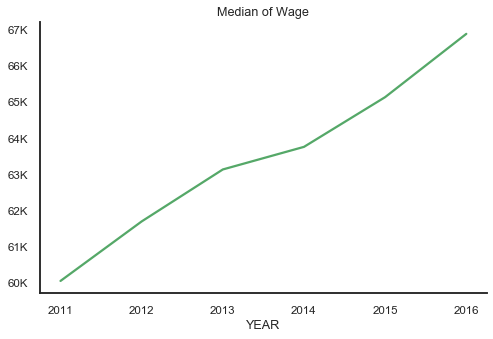

In [247]:
# Plot the line chart
ax = df_wage.groupby("YEAR")["PREVAILING_WAGE"].median().plot(kind="line",figsize=(8, 5), color ="g")

# Format axis number
f = lambda y, pos: f'{y/10**3:,.0f}K'
ax.yaxis.set_major_formatter(FuncFormatter(f))

# Finalize the plot
sns.despine(bottom=False)
plt.title("Median of Wage")
plt.show()

In [174]:
# Calculate annual wage growth rate
wage_clean_median = df_wage.groupby("YEAR").PREVAILING_WAGE.median().to_frame("Wage")
wage_clean_pct = wage_clean_median.pct_change().style.format({"Wage": "{:,.2%}".format})
wage_clean_pct

,Wage
YEAR,
2011,nan%
2012,2.74%
2013,2.33%
2014,0.99%
2015,2.15%
2016,2.68%


The median of all H1B application wage **increases from 63K to 70K** during 2011 and 2016. If we compare the annual growth rate to entire US hourly wage data, which is betweem 1.9% and 3%, it is consistent. In other words, the **wage growth rate among H1B jobs does not outdo overall US job market**.  

(Sources: Federal Reserve Bank of Atlantac https://www.frbatlanta.org/chcs/wage-growth-tracker)

### 5. Deep dive into Data Jobs
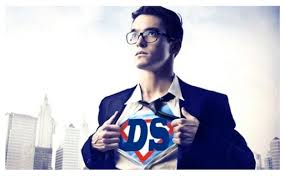

Many say "Data Scientist is the Sexiest Job of the 21st Century". In this section we will deep dive into H1B data jobs by looking at 3 job titles: **Data Analyst, Data Scientist and Data Engineer**.

Image via https://www.johnsnowlabs.com/data-scientist-21st-century-sexiest-job-for-free/

In [29]:
# Clean dataset under Job Title
df_title = df.dropna(subset=["JOB_TITLE"])
df_title_da = df_title[df_title["JOB_TITLE"].str.contains("DATA ANALYST")]
df_title_ds = df_title[df_title["JOB_TITLE"].str.contains("DATA SCIENTIST")]
df_title_de = df_title[df_title["JOB_TITLE"].str.contains("DATA ENGINEER")]

#### Number of Data Jobs

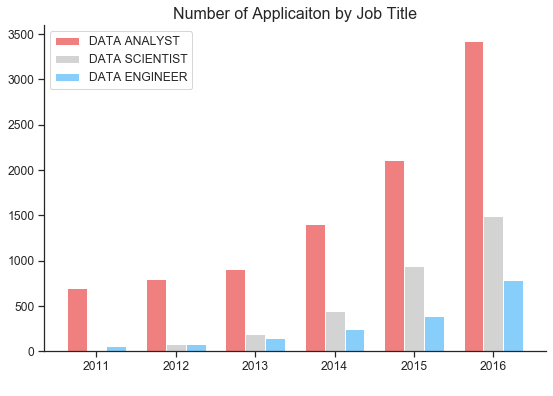

In [291]:
# Initialize the figure
plt.figure(figsize=(9, 6))
barWidth = 0.25
 
# Set height of bar
bars1 = df_title_da.groupby("YEAR")["CASE_STATUS"].count()
bars2 = df_title_ds.groupby("YEAR")["CASE_STATUS"].count()
bars3 = df_title_de.groupby("YEAR")["CASE_STATUS"].count()

# Set position of bar on x-axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Plot 3 bar charts
plt.bar(r1, bars1, color='#F08080', width=barWidth, edgecolor='white', label='DATA ANALYST')
plt.bar(r2, bars2, color='#D3D3D3', width=barWidth, edgecolor='white', label='DATA SCIENTIST')
plt.bar(r3, bars3, color='#87CEFA', width=barWidth, edgecolor='white', label='DATA ENGINEER')

# Add xticks on the middle of the group bars
plt.xlabel(" ", fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], range(2011, 2017))
 
# Finalize the plot
plt.legend()
plt.title("Number of Applicaiton by Job Title", fontsize=16)
sns.despine(bottom=False)
plt.show()


**Data jobs are indeed "hot jobs" with rapid growth in the States**. Most are hired as Data Analyst, which increases almost 5 times during this period.

#### Wage of Data Jobs

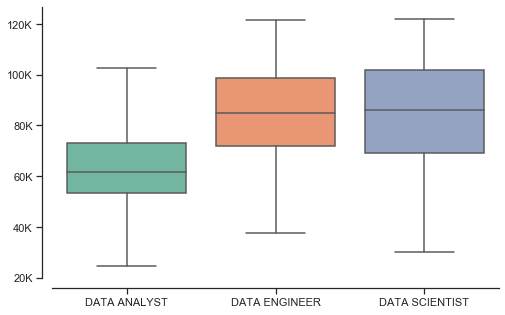

In [20]:
# Extract dataset of wage by job title: Data Analyst, Data Engineer and Data Scientist
df_title_clean = df_wage.dropna(subset=["JOB_TITLE"])
df_da = df_title_clean[df_title_clean.JOB_TITLE.str.contains("DATA ANALYST")].PREVAILING_WAGE
df_de = df_title_clean[df_title_clean.JOB_TITLE.str.contains("DATA ENGINEER")].PREVAILING_WAGE
df_ds = df_title_clean[df_title_clean.JOB_TITLE.str.contains("DATA SCIENTIST")].PREVAILING_WAGE

data_job = pd.concat([df_da, df_de, df_ds], axis=1)
data_job.columns = ["DATA ANALYST","DATA ENGINEER", "DATA SCIENTIST"]

# Initialize the figure
sns.set(style="ticks", palette="Set2", font_scale=1)
f, ax = plt.subplots(figsize =(8,5)) 

# Plot the boxplot
ax = sns.boxplot(data=data_job, showfliers=False)

# Format axis number
f = lambda y, pos: f'{y/10**3:,.0f}K'
ax.yaxis.set_major_formatter(FuncFormatter(f))

# Finalize the plot
sns.despine(offset=10)

Compared to Data Analyst, **Data Scientist and Data Engineer earn significantly more**.

#### Top 10 Data Job Employers

In [21]:
df1 = df.copy()
df1 = df1.dropna(subset=["JOB_TITLE"])

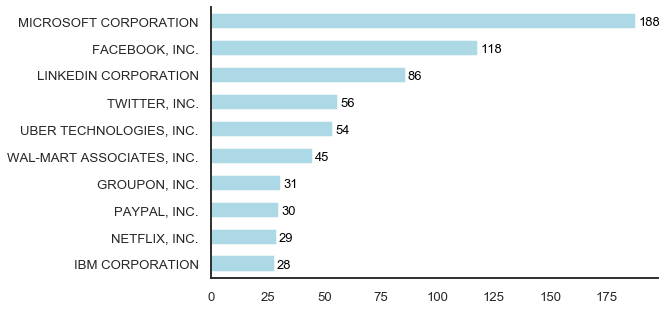

In [22]:
# Extract dataset with data jobs
for t in ["DATA ANALYST", "DATA ENGINEER", "DATA SCIENTIST"]:
    a = df1[df1.JOB_TITLE.str.contains(t)]
    data_emp = pd.concat([a], axis=1)
    
emp_10 = data_emp.EMPLOYER_NAME.value_counts().sort_values().tail(10)

# Plot top 10 employers with data jobs
sns.set(style="white", context="talk",font_scale=0.8)
ax = emp_10.plot(kind="barh", width=0.6, color='lightblue', figsize=(8, 5))

# Add value labels 
for i, v in enumerate(emp_10.values): 
    ax.text(emp_10[i]+1, i-0.05, v, fontsize=13, color='black', va='center')
    
# Finalize the plot
sns.despine(bottom=False)

The companies with most data jobs are mainly in **tech industry**. We can then visualize the job location according to the number of jobs.

#### Locaiton of Data Jobs

In [296]:
loc_count = data_emp.groupby(["WORKSITE","lon","lat"])["CASE_STATUS"].count().to_frame("counts").reset_index()
locate = loc_count[['lat','lon']]
count = loc_count['counts']

# Initialize map
emp_map = folium.Map(location=[32, -95], tiles="CartoDB positron", zoom_start=3.5)

# Color based on  number of visa application
def color(count):
    if count < 20:
        return "darkblue"
    elif 20 <= count < 70:
        return "gray"
    else:
        return "cadetblue"

# Create map
for loc in loc_count.index:
    folium.CircleMarker(list(locate.loc[loc]),     
                        radius=count.loc[loc]*0.15, color=color(count.loc[loc]),
                        popup="Number of Application:" +str(count.loc[loc]),
                        fill_color=color_producer(count.loc[loc]), fill=True
                        ).add_to(emp_map)
emp_map.save("Data_Employer_map.html")

In [303]:
import os
import webbrowser
webbrowser.open("Data_Employer_map.html")

True

Not surprisingly, the top 2 biggest areas are **San Francisco and New York**. Other popular areas include **Seattle, Chicago and Atlanta**. For international students major in Data Science, targeting these areas is a good strategy for job opportunities.

**THANK YOU!**